In [9]:
!pip install tensorflow opencv-python-headless gradio ultralytics supervision

In [10]:
import cv2
import numpy as np
import tensorflow as tf
from ultralytics import YOLO
import gradio as gr

In [11]:
tf.config.list_physical_devices('GPU')

[]

In [12]:
# load libraries
from huggingface_hub import hf_hub_download
from ultralytics import YOLO
from supervision import Detections
from PIL import Image

# download model
model_path = hf_hub_download(repo_id="arnabdhar/YOLOv8-Face-Detection", filename="model.pt")

# load model
yolo_face_model = YOLO(model_path)

In [13]:
from transformers import pipeline

# Loading the pipeline for image classification using the Hugging Face model
emotion_pipe = pipeline('image-classification', model='gerhardien/face-emotion', device=0)

Device set to use cpu


In [20]:
import gradio as gr
import cv2
from PIL import Image, ImageDraw, ImageFont
import numpy as np

# URL of the font file
import requests, io
font_url = "https://github.com/google/fonts/raw/refs/heads/main/ofl/courierprime/CourierPrime-BoldItalic.ttf"

# Fetch the font file from the URL
response = requests.get(font_url)
if response.status_code == 200:
    with open('fonts.ttf', "wb") as file:
        file.write(response.content)
    print(f"Font successfully downloaded and saved as fonts.ttf")
else:
    print(f"Failed to fetch font: {response.status_code}.")


# Adjust font size to fit text into the bounding box width.
def fit_text_to_box(draw, text, box_width, max_font_size=200, min_font_size=5):

    font_size = max_font_size
    font = None
    while font_size >= min_font_size:
        font = ImageFont.truetype("fonts.ttf", size=font_size)
        # Calculate the bounding box of the text
        text_bbox = draw.textbbox((0, 0), text, font=font)
        text_width = text_bbox[2] - text_bbox[0]  # width of the bounding box

        if text_width <= box_width:
            break
        font_size -= 1

    if font is None:
        raise ValueError("Text cannot fit within the bounding box.")
    return font

def process_frame(frame):
    ###########################################################################
    # Convert the OpenCV frame (NumPy array) to a PIL Image
    pil_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    # Perform face detection with YOLO model
    output = yolo_face_model(pil_image)

    # Convert the YOLO model's output to detections (assumed to be in 'results' variable)
    results = Detections.from_ultralytics(output[0])

    draw = ImageDraw.Draw(pil_image)
    font = ImageFont.truetype('fonts.ttf', size=60)

    # Iterate through detections
    for box, label, score in zip(results.xyxy, results.class_id, results.confidence):
        # Get bounding box coordinates
        x1, y1, x2, y2 = box  # (xmin, ymin, xmax, ymax)

        # Draw rectangle
        draw.rectangle([x1, y1, x2, y2], outline="red", width=2)

        box_width = x2 - x1

        cropped_image = pil_image.crop((x1, y1, x2, y2))

        res=emotion_pipe(cropped_image)

        font = fit_text_to_box(draw, f"{res[0]['label']} {res[0]['score']:.2f}", box_width)

        draw.text((x1, y1+2),f"{res[0]['label']} {res[0]['score']:.2f}", fill="green", font=font)

        processed_frame = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)

    return processed_frame


def video_stream(video_frame):
    return process_frame(video_frame)


Font successfully downloaded and saved as fonts.ttf


In [23]:
import gradio as gr

with gr.Blocks() as demo:
    with gr.Row():
        with gr.Column():
            gr.Markdown("# Input Live Video")  # Heading for live video
            input_img = gr.Image(label="Input Live Video")

            gr.Markdown("# Input Image")  # Heading for static image
            input_img_static = gr.Image(label="Input Image")
        with gr.Column():
            gr.Markdown("# Output")  # Heading for output
            output_img = gr.Image(label="Output")

    # Define the streaming functionality
    input_img.stream(process_frame, input_img, output_img, time_limit=25, stream_every=0.5, concurrency_limit=30)
    input_img_static.change(process_frame, inputs=input_img_static, outputs=output_img)

demo.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c8278de93a8b61f4a6.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Font successfully downloaded and saved as fonts.ttf

0: 640x640 7 FACEs, 580.3ms
Speed: 46.9ms preprocess, 580.3ms inference, 38.0ms postprocess per image at shape (1, 3, 640, 640)


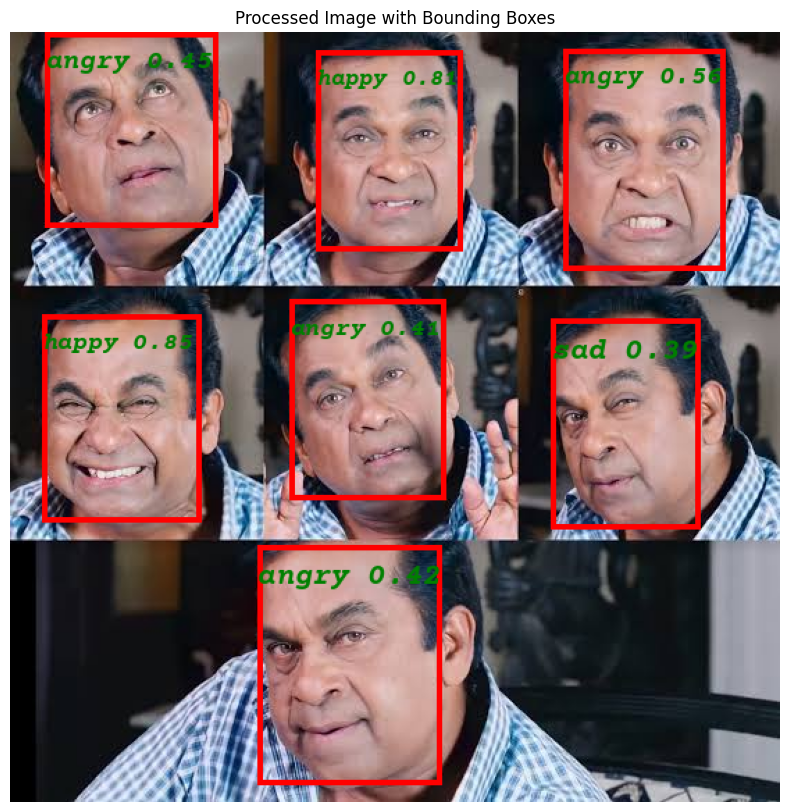

In [17]:
############################TESTING#############################

import cv2
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt

# URL of the font file (replace with the desired CDN link)
import requests
font_url = "https://github.com/google/fonts/raw/refs/heads/main/ofl/courierprime/CourierPrime-BoldItalic.ttf"

# Fetch the font file from the URL
response = requests.get(font_url)
if response.status_code == 200:
    with open('fonts.ttf', "wb") as file:
        file.write(response.content)
    print(f"Font successfully downloaded and saved as fonts.ttf")
else:
    print(f"Failed to fetch font: {response.status_code}.")

def fit_text_to_box(draw, text, box_width, max_font_size=200, min_font_size=5):
    """
    Adjust font size to fit text into the bounding box width.
    """
    font_size = max_font_size
    font = None
    while font_size >= min_font_size:
        font = ImageFont.truetype("fonts.ttf", size=font_size)
        # Calculate the bounding box of the text
        text_bbox = draw.textbbox((0, 0), text, font=font)
        text_width = text_bbox[2] - text_bbox[0]  # width of the bounding box

        if text_width <= box_width:
            break
        font_size -= 1

    if font is None:
        raise ValueError("Text cannot fit within the bounding box.")
    return font


def process_image(image_path):
    """
    Process a static image and display it with bounding boxes and text.
    """
    # Open the image from the file path
    pil_image = Image.open(image_path)  # Ensure it's in RGB format

    # Perform face detection with YOLO model
    output = yolo_face_model(pil_image)

    # Convert the YOLO model's output to detections (assumed to be in 'results' variable)
    results = Detections.from_ultralytics(output[0])

    draw = ImageDraw.Draw(pil_image)

    # Iterate through detections
    for box, label, score in zip(results.xyxy, results.class_id, results.confidence):
        # Get bounding box coordinates
        x1, y1, x2, y2 = box  # (xmin, ymin, xmax, ymax)

        # Draw rectangle
        draw.rectangle([x1, y1, x2, y2], outline="red", width=4)

        box_width = x2 - x1

        cropped_image = pil_image.crop((x1, y1, x2, y2))

        res = emotion_pipe(cropped_image)

        # Adjust font size to fit within the bounding box
        font = fit_text_to_box(draw, f"{res[0]['label']} {res[0]['score']:.2f}", box_width)

        # Draw text above the bounding box
        draw.text((x1, y1 + 10), f"{res[0]['label']} {res[0]['score']:.2f}", fill="green", font=font)

    # Display the image using matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(pil_image)
    plt.axis("off")
    plt.title("Processed Image with Bounding Boxes")
    plt.show()

# Provide the path to your static image
image_path = "/content/WhatsApp Image 2024-12-26 at 7.11.23 PM.jpeg"

# Call the function to process and display the image
process_image(image_path)

